In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Multiply, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Pre-trained DenseNet201
pretrained_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pretrained_model.trainable = True  # Fine-tune all layers

# Attention Mechanism with SE Blocks
def attention_block(inputs):
    attention_data = GlobalAveragePooling2D()(inputs)
    attention_data = Dense(128, activation='relu')(attention_data)
    attention_weights = Dense(inputs.shape[-1], activation='sigmoid')(attention_data)
    attention_weights = Lambda(lambda x: tf.expand_dims(tf.expand_dims(x, 1), 1))(attention_weights)
    return Multiply()([inputs, attention_weights])

# Input Layer
inp = Input(shape=(224, 224, 3))
densenet = pretrained_model(inp)

# Apply Attention Block
attention_features = attention_block(densenet)

# Global Pooling and Fully Connected Layers
X = GlobalAveragePooling2D()(attention_features)
X = BatchNormalization()(X)
X = Dense(256, activation='elu')(X)
X = Dropout(0.4)(X)  # Increased dropout for better generalization

X = Dense(128, activation='elu')(X)
X = Dropout(0.3)(X)

X = Dense(64, activation='elu')(X)
X = BatchNormalization()(X)  # Added Batch Normalization

# Output Layer
out = Dense(5, activation='softmax')(X)

model = Model(inputs=inp, outputs=out)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Fine-tuned learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Data Generators with Enhanced Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Directory Paths (update these as necessary)
train_dir = '/kaggle/input/segmented-dental-radiography/Segmented Dental Radiography/train'
valid_dir = '/kaggle/input/segmented-dental-radiography/Segmented Dental Radiography/valid'
test_dir = '/kaggle/input/segmented-dental-radiography/Segmented Dental Radiography/test'

# Load Data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='sparse')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='sparse')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='sparse')

# Callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train Model
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    callbacks=my_callbacks)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2024-08-16 01:55:47.122598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 01:55:47.122708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 01:55:47.315091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 25410 images belonging to 5 classes.
Found 2721 images belonging to 5 classes.
Found 1714 images belonging to 5 classes.
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723773769.698916      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723773770.050839      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


571/795 ━━━━━━━━━━━━━━━━━━━━ 2:19 623ms/step - accuracy: 0.6619 - loss: 1.0734

2024-08-16 02:12:20.220596: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_133436__.91124] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-16 02:12:36.469860: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m16.249391335s

********************************
[Compiling module a_inference_one_step_on_data_133436__.91124] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


572/795 ━━━━━━━━━━━━━━━━━━━━ 3:49 1s/step - accuracy: 0.6621 - loss: 1.0728   

W0000 00:00:1723774356.738468      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


795/795 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7008 - loss: 0.9710

W0000 00:00:1723774515.817599      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


795/795 ━━━━━━━━━━━━━━━━━━━━ 1150s 991ms/step - accuracy: 0.7009 - loss: 0.9706 - val_accuracy: 0.9140 - val_loss: 0.3344 - learning_rate: 1.0000e-04
Epoch 2/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 411s 512ms/step - accuracy: 0.8844 - loss: 0.4244 - val_accuracy: 0.9089 - val_loss: 0.2800 - learning_rate: 1.0000e-04
Epoch 3/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 411s 512ms/step - accuracy: 0.9029 - loss: 0.3286 - val_accuracy: 0.9136 - val_loss: 0.2756 - learning_rate: 1.0000e-04
Epoch 4/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 413s 514ms/step - accuracy: 0.9042 - loss: 0.3044 - val_accuracy: 0.9346 - val_loss: 0.2306 - learning_rate: 1.0000e-04
Epoch 5/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 407s 507ms/step - accuracy: 0.9159 - loss: 0.2635 - val_accuracy: 0.9085 - val_loss: 0.2815 - learning_rate: 1.0000e-04
Epoch 6/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 407s 507ms/step - accuracy: 0.9216 - loss: 0.2455 - val_accuracy: 0.8798 - val_loss: 0.3570 - learning_rate: 1.0000e-04
Epoch 7/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 410s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



795/795 ━━━━━━━━━━━━━━━━━━━━ 405s 504ms/step - accuracy: 0.9669 - loss: 0.1016 - val_accuracy: 0.9331 - val_loss: 0.2382 - learning_rate: 1.0000e-04
Epoch 25/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 405s 504ms/step - accuracy: 0.9673 - loss: 0.0983 - val_accuracy: 0.9357 - val_loss: 0.2138 - learning_rate: 1.0000e-04
Epoch 26/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 405s 504ms/step - accuracy: 0.9663 - loss: 0.0972 - val_accuracy: 0.9136 - val_loss: 0.3093 - learning_rate: 1.0000e-04
Epoch 27/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 404s 504ms/step - accuracy: 0.9458 - loss: 0.1597 - val_accuracy: 0.9423 - val_loss: 0.1997 - learning_rate: 1.0000e-04
Epoch 28/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 404s 503ms/step - accuracy: 0.9769 - loss: 0.0739 - val_accuracy: 0.9467 - val_loss: 0.1933 - learning_rate: 1.0000e-05
Epoch 29/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 409s 510ms/step - accuracy: 0.9803 - loss: 0.0611 - val_accuracy: 0.9456 - val_loss: 0.1988 - learning_rate: 1.0000e-05
Epoch 30/100
795/795 ━━━━━━━━━━━━━━━━━━━━

W0000 00:00:1723787278.698614      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step


W0000 00:00:1723787561.332269      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


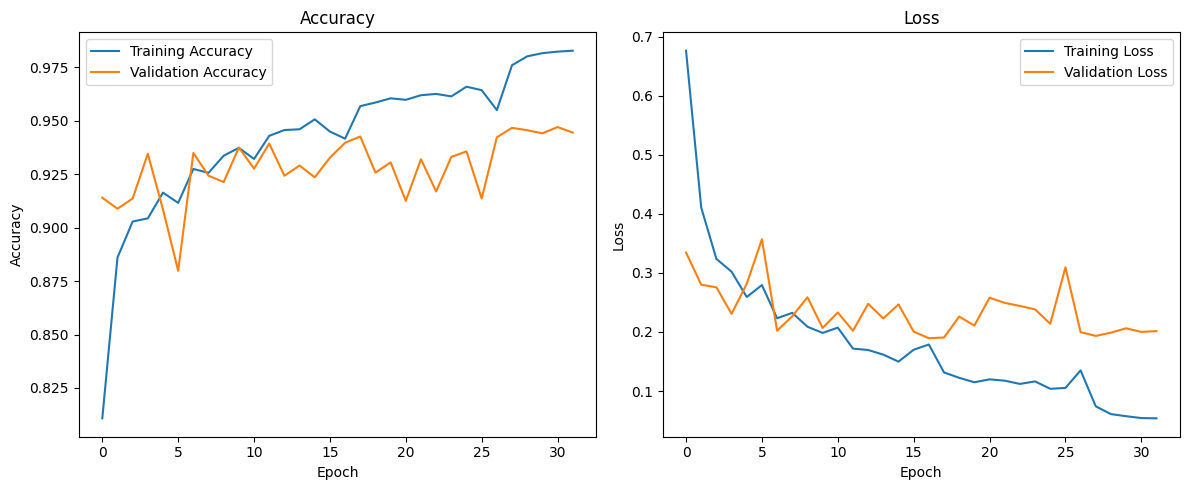

Validation Confusion Matrix:


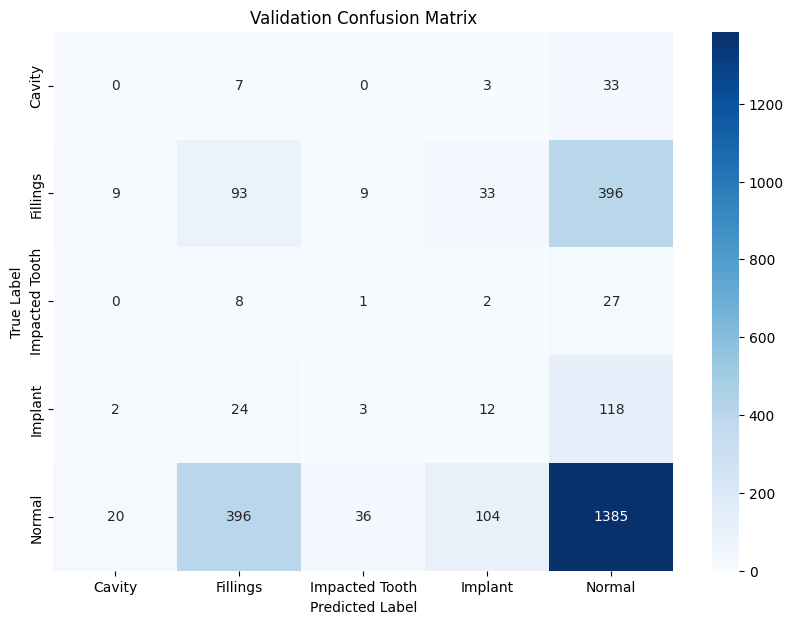


Validation Classification Report:
                precision    recall  f1-score   support

        Cavity       0.00      0.00      0.00        43
      Fillings       0.18      0.17      0.17       540
Impacted Tooth       0.02      0.03      0.02        38
       Implant       0.08      0.08      0.08       159
        Normal       0.71      0.71      0.71      1941

      accuracy                           0.55      2721
     macro avg       0.20      0.20      0.20      2721
  weighted avg       0.54      0.55      0.55      2721

Test Confusion Matrix:


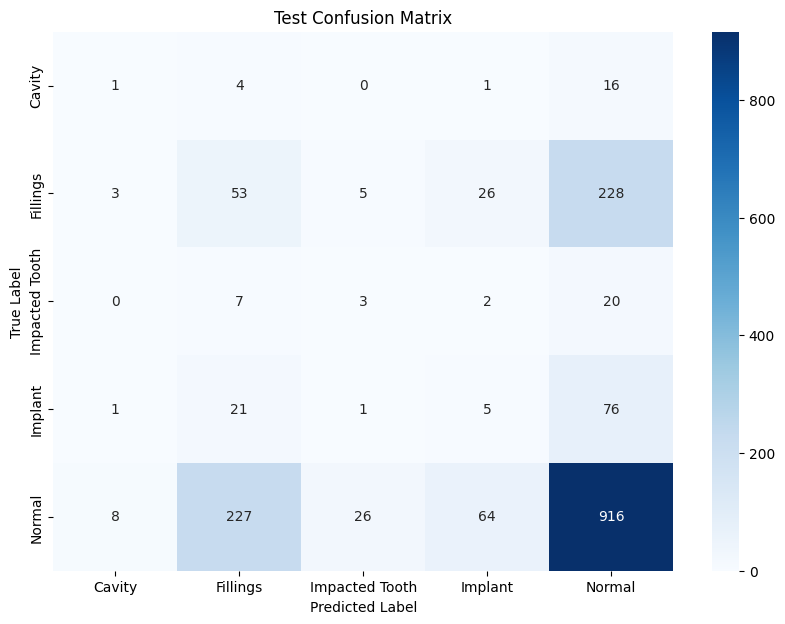


Test Classification Report:
                precision    recall  f1-score   support

        Cavity       0.08      0.05      0.06        22
      Fillings       0.17      0.17      0.17       315
Impacted Tooth       0.09      0.09      0.09        32
       Implant       0.05      0.05      0.05       104
        Normal       0.73      0.74      0.73      1241

      accuracy                           0.57      1714
     macro avg       0.22      0.22      0.22      1714
  weighted avg       0.56      0.57      0.57      1714



In [7]:
import numpy as np
valid_labels = valid_generator.classes
valid_predictions = model.predict(valid_generator)
valid_predictions = np.argmax(valid_predictions, axis=1)

# Get true labels and predictions for the test set
test_labels = test_generator.classes
test_predictions = model.predict(test_generator)
test_predictions = np.argmax(test_predictions, axis=1)

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plotting training history
history_dict = history.history

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming you have true labels and predictions for validation and test sets
class_names = list(train_generator.class_indices.keys())

# Calculate confusion matrix and classification report for validation
valid_cm = confusion_matrix(valid_labels, valid_predictions)
print("Validation Confusion Matrix:")
plot_confusion_matrix(valid_cm, class_names, title='Validation Confusion Matrix')
print("\nValidation Classification Report:")
print(classification_report(valid_labels, valid_predictions, target_names=class_names))

# Calculate confusion matrix and classification report for test set
test_cm = confusion_matrix(test_labels, test_predictions)
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names, title='Test Confusion Matrix')
print("\nTest Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))
